# Model comparisons

Plan to test
- Random forest
- CNN
- Kernel SVM ?
- Gradient Boosting ?

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("G:/My Drive/Erdos/Fall2022_Juniper/train.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

No missing data

## Checking correlation

In [12]:
corr = data.corr()

<AxesSubplot:>

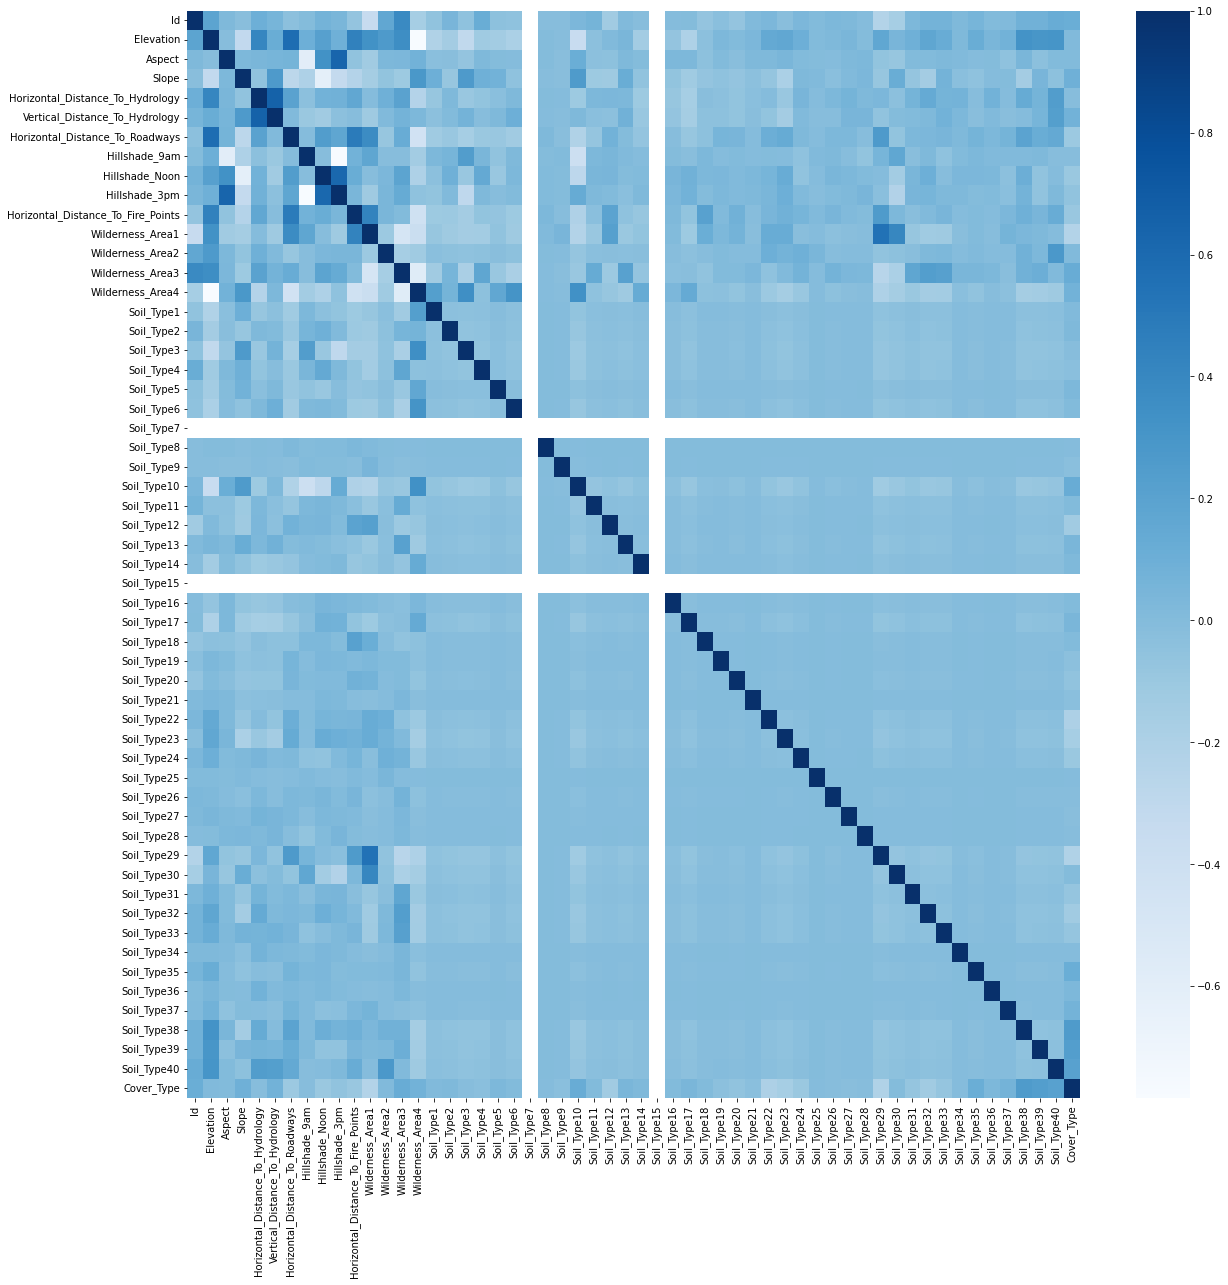

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr,cmap='Blues')

Soil_type7 and Soil_type15 don't have any correlations with Cover_Type, so they can be removed for the predition.

In [51]:
corr_high = corr.unstack()
corr_high = corr_high[abs(corr_high) >= 0.6]
corr_high = corr_high[abs(corr_high) < 1]
corr_high.sort_values(key=abs)

Slope                             Hillshade_Noon                     -0.612613
Hillshade_Noon                    Slope                              -0.612613
                                  Hillshade_3pm                       0.614526
Hillshade_3pm                     Hillshade_Noon                      0.614526
Aspect                            Hillshade_3pm                       0.635022
Hillshade_3pm                     Aspect                              0.635022
Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology      0.652142
Vertical_Distance_To_Hydrology    Horizontal_Distance_To_Hydrology    0.652142
Hillshade_9am                     Hillshade_3pm                      -0.779965
Hillshade_3pm                     Hillshade_9am                      -0.779965
Elevation                         Wilderness_Area4                   -0.783651
Wilderness_Area4                  Elevation                          -0.783651
dtype: float64

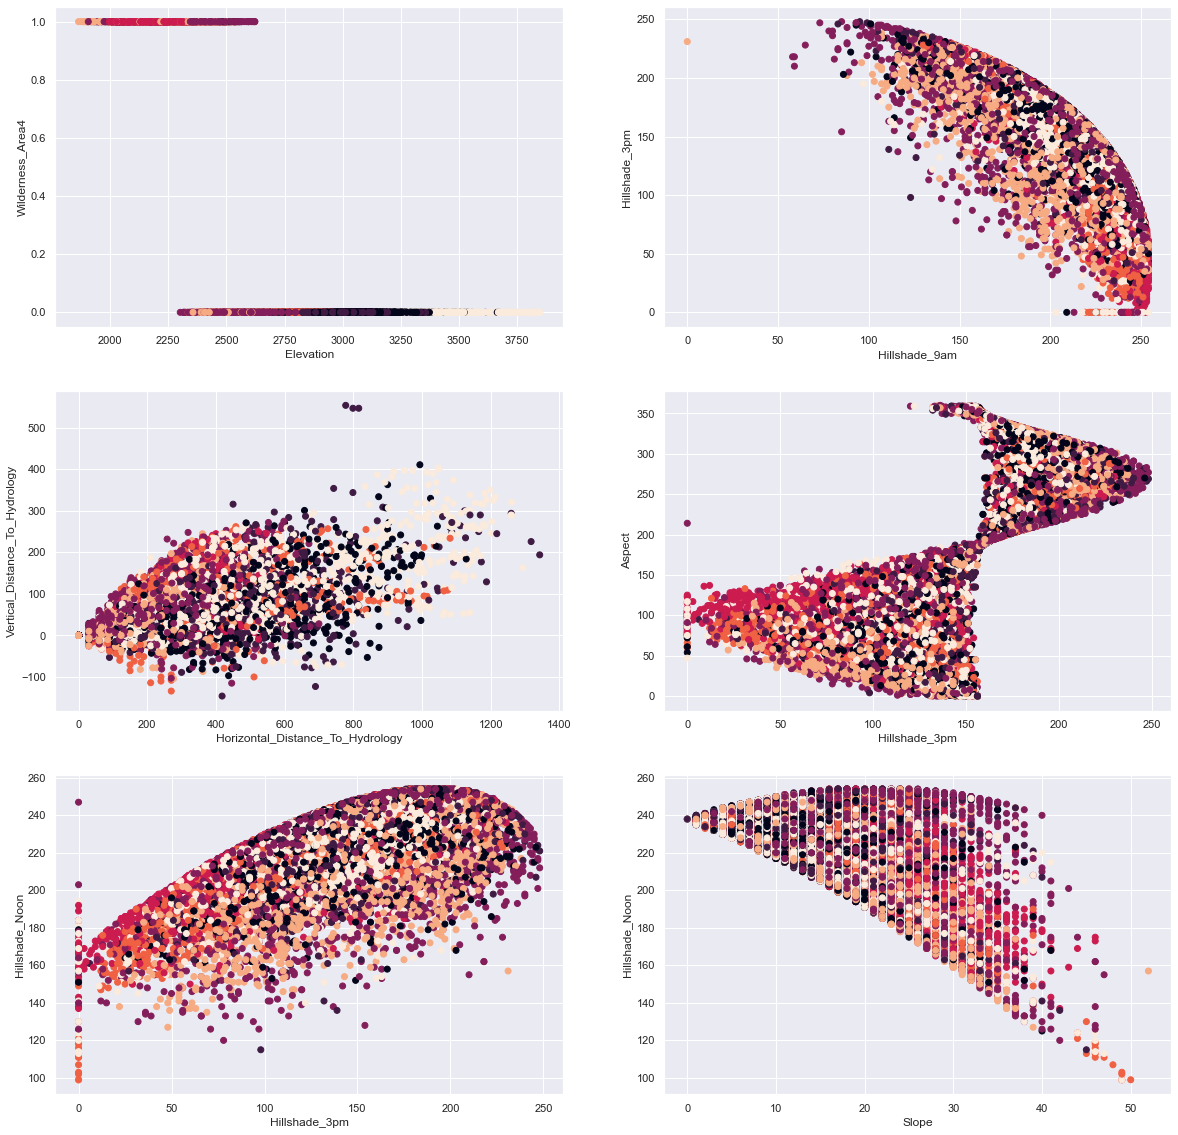

In [59]:
figure, axis = plt.subplots(3,2,figsize=(20,20))

axis[0, 0].scatter(data.Elevation, data.Wilderness_Area4,c = data.Cover_Type)
axis[0, 0].set(xlabel='Elevation', ylabel='Wilderness_Area4')

axis[0, 1].scatter(data.Hillshade_9am, data.Hillshade_3pm,c = data.Cover_Type)
axis[0, 1].set(xlabel='Hillshade_9am', ylabel='Hillshade_3pm')

axis[2, 1].scatter(data.Slope, data.Hillshade_Noon,c = data.Cover_Type)
axis[2, 1].set(xlabel='Slope', ylabel='Hillshade_Noon')

axis[2, 0].scatter(data.Hillshade_3pm, data.Hillshade_Noon,c = data.Cover_Type)
axis[2, 0].set(xlabel='Hillshade_3pm', ylabel='Hillshade_Noon')

axis[1, 1].scatter(data.Hillshade_3pm, data.Aspect,c = data.Cover_Type)
axis[1, 1].set(xlabel='Hillshade_3pm', ylabel='Aspect')

axis[1, 0].scatter(data.Horizontal_Distance_To_Hydrology, data.Vertical_Distance_To_Hydrology,c = data.Cover_Type)
axis[1, 0].set(xlabel = "Horizontal_Distance_To_Hydrology", ylabel = "Vertical_Distance_To_Hydrology")


plt.show()


They seem to have some relationships. How can I add them to features?

## Train test data split

In [40]:
data1 = data.copy(deep=True)
X = data1.drop(['Cover_Type', "Soil_Type7", "Soil_Type15"],axis=1)
y = data1['Cover_Type']

implement cross-validataion later-
kfold = KFold(n_splits = 5, shuffle = True, random_state = 314)

In [41]:
X_train,X_test, y_train, y_test = train_test_split(X,y,
                               shuffle = True,
                               random_state=314,
                               test_size=0.3)

In [42]:
unique, count= np.unique(y_train, return_counts=True)
print("The number of occurances of each class = %s " % dict (zip(unique, count) ), "\n" )

The number of occurances of each class = {1: 1521, 2: 1496, 3: 1522, 4: 1483, 5: 1525, 6: 1477, 7: 1560}  



C:\Users\m0eka\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

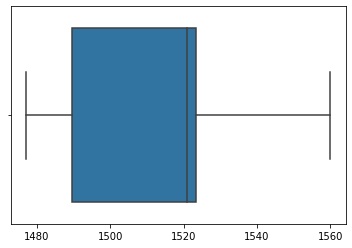

In [43]:
sns.boxplot(count)

No outliers. The number of occurances in each class are roughly similar.

## Random Forest - Base model

No need for standard scaling. Find the best accuracy scores with n_estimators of 100, 200, 300, and 400.

In [46]:
rf_accuracy = {}
for i in range(1,5):
    rf = RandomForestClassifier(n_estimators = 100*i)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    rf_accuracy[100*i] = round(accuracy_score(y_test, y_pred),4)
print(rf_accuracy)

{100: 0.8613, 200: 0.8646, 300: 0.869, 400: 0.8699}


n_estimators of 400 has the highest accuracy among 4. So, let's use this for the later analysis.

In [47]:
rf = RandomForestClassifier(n_estimators = 400)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

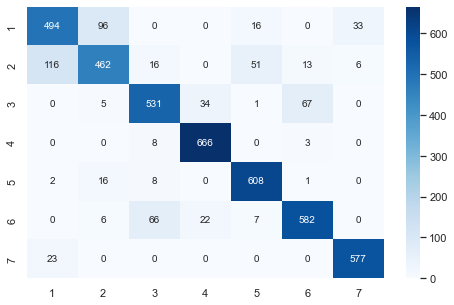

In [49]:
rf_confusion = confusion_matrix(y_test,y_pred)
rf_cm = pd.DataFrame(rf_confusion, 
                     index = [i for i in "1234567"],
                     columns = [i for i in "1234567"])
plt.figure(figsize=(8,5))
sns.set(font_scale=1)
sns.heatmap(rf_cm,annot=True,fmt='g', cmap='Blues',
           annot_kws={"size": 10})
plt.show()

In [50]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Random Forest Model')
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, 
                            target_names=['1','2','3','4','5','6','7']))

Random Forest Model

Accuracy: 0.86

Micro Precision: 0.86
Micro Recall: 0.86
Micro F1-score: 0.86

Macro Precision: 0.86
Macro Recall: 0.87
Macro F1-score: 0.86

Weighted Precision: 0.86
Weighted Recall: 0.86
Weighted F1-score: 0.86

Classification Report

              precision    recall  f1-score   support

           1       0.78      0.77      0.78       639
           2       0.79      0.70      0.74       664
           3       0.84      0.83      0.84       638
           4       0.92      0.98      0.95       677
           5       0.89      0.96      0.92       635
           6       0.87      0.85      0.86       683
           7       0.94      0.96      0.95       600

    accuracy                           0.86      4536
   macro avg       0.86      0.87      0.86      4536
weighted avg       0.86      0.86      0.86      4536

